### Imports

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import random
import math
from itertools import count
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

### Hyperparameters

In [64]:
# DQL constants
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 1200
TARGET_UPDATE_EVERY = 20
LEARNING_RATE = 5e-4
NUM_EPISODES = 2000

# Environment constants
ENV_SIZE = 45
MAX_ENV_STEPS = 100
MAX_ENV_STEPS_SIMU = 300
POP_DENSITY = 0.2
ZOMBIE_FRACTION = 0.25
VISIBILITY = 9 # square's half side length
STATE_ROOT_SIZE = 2 * VISIBILITY + 1
STATE_SIZE = STATE_ROOT_SIZE**2
ACTION_SIZE = 5 # 4 directions + do nothing
ZOMBIE_VISIBILITY = 7
WARMUP_TIME = 20
B = 1.35

DEATH_REWARD = -20
KILL_REWARD = 2
REST_REWARD = 0
MOVE_REWARD = 0
SURVIVE_REWARD = 20

EMPTY_CELL = 0
HUMAN_CELL = 1
AGENT_CELL = 2
ZOMBIE_CELL = 3
# BGR encoding for some reason 
colors = {EMPTY_CELL: (0, 0, 0),
          HUMAN_CELL: (0, 180, 0),
          AGENT_CELL: (255, 200, 200),
          ZOMBIE_CELL: (0, 0, 180)}

# Printing and visualization constants
SHOW_ENV = False
SHOW_ENV_EVERY = 20
AGGREGATE_STATS_EVERY = 40

### Device selection

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Function definitions

### The Environment

In [66]:
class Environment():
        
    def __init__(self):
        print("Initializing environment")
    
    def multireset(self):
        self.grid = np.zeros((ENV_SIZE, ENV_SIZE), dtype=np.uint8)
        
        ## place people and zombies
        rands = [random.uniform(0, 1) for i in range(ENV_SIZE**2)]
        r = random.randint(0, ENV_SIZE**2-1)
        self.humans_pos = []
        self.zombies_pos = []
        for y in range(ENV_SIZE):
            for x in range(ENV_SIZE):
                if rands[y * ENV_SIZE + x] < POP_DENSITY:
                    if rands[y * ENV_SIZE + x] < POP_DENSITY * ZOMBIE_FRACTION:
                        self.grid[y, x] = ZOMBIE_CELL
                        self.zombies_pos.append((y, x))
                    else:
                        self.grid[y, x] = HUMAN_CELL
                        self.humans_pos.append((y, x))

        self.episode_step = 0
    
    def reset(self):
        ## generate grid
        self.grid = np.zeros((ENV_SIZE, ENV_SIZE), dtype=np.uint8)
        
        ## place people and zombies
        rands = [random.uniform(0, 1) for i in range(ENV_SIZE**2)]
        r = random.randint(0, ENV_SIZE**2-1)
        self.humans_pos = []
        self.zombies_pos = []
        for y in range(ENV_SIZE):
            for x in range(ENV_SIZE):
                if rands[y * ENV_SIZE + x] < POP_DENSITY:
                    if rands[y * ENV_SIZE + x] < POP_DENSITY * ZOMBIE_FRACTION:
                        self.grid[y, x] = ZOMBIE_CELL
                        self.zombies_pos.append((y, x))
                    else:
                        self.grid[y, x] = HUMAN_CELL
                        self.humans_pos.append((y, x))
                    
        # place agent
        self.agent_x = random.randint(0, ENV_SIZE-1)
        self.agent_y = random.randint(0, ENV_SIZE-1)
        while self.grid[self.agent_y, self.agent_x] != EMPTY_CELL:
            self.agent_x = random.randint(0, ENV_SIZE-1)
            self.agent_y = random.randint(0, ENV_SIZE-1)
        self.grid[self.agent_y, self.agent_x] = AGENT_CELL
        
        # remove zombies too close to the agent when the episode starts
        for y in [(self.agent_y-1)%ENV_SIZE, self.agent_y, (self.agent_y+1)%ENV_SIZE]:
            for x in [(self.agent_x-1)%ENV_SIZE, self.agent_x, (self.agent_x+1)%ENV_SIZE]:
                if self.grid[y, x] == ZOMBIE_CELL:
                    self.grid[y, x] = EMPTY_CELL
                    self.zombies_pos.remove((y, x))
        
        self.episode_step = 0
        state = self.scan_env(self.agent_x, self.agent_y)
        
        return state
    
    def step(self, action):
        self.episode_step += 1
        self.perform_action(action)
        self.zombies_pos = self.move_zombies_chase()
        for y,x in self.zombies_pos:
            assert self.grid[y,x] == ZOMBIE_CELL
        
        dead_humans = set()
        dead_zombies = set()
        
        nb_allies, enemies = self.scan_vicinity(self.agent_x, self.agent_y)
        
        # Handle agent's interactions
        dead = False
        reward = REST_REWARD if action == 0 else MOVE_REWARD
        if len(enemies) > 0: # Contact
            for enemy in enemies:
                r = np.random.uniform(0, 1)
                b = B
                k = (1 + nb_allies*4) # << S
                if r >= b/(b+k): # kill
                    reward += KILL_REWARD
                    assert self.grid[enemy] == ZOMBIE_CELL
                    self.grid[enemy] = EMPTY_CELL
                    dead_zombies.add(enemy)
                else: # death
                    reward += DEATH_REWARD
                    dead = True
                    break
        
        if self.episode_step >= MAX_ENV_STEPS:
            reward += SURVIVE_REWARD
        done = self.episode_step >= MAX_ENV_STEPS or dead
        
        # Handle all other interactions
        for (y, x) in self.humans_pos:
            assert self.grid[y, x] == HUMAN_CELL
            nb_allies, enemies = self.scan_vicinity(x, y)
            if len(enemies) > 0:
                for enemy in enemies:
                    r = np.random.uniform(0, 1)
                    b = B
                    k = 1 + nb_allies*2 # << S
                    if r >= b/(b+k): # kill
                        assert self.grid[enemy] == ZOMBIE_CELL
                        self.grid[enemy] = EMPTY_CELL
                        dead_zombies.add(enemy)
                    else: # death
                        assert self.grid[y, x] == HUMAN_CELL
                        self.grid[y, x] = ZOMBIE_CELL
                        self.zombies_pos.append((y, x))
                        dead_humans.add((y, x))
                        break
        
        # Clean the dead
        for dead_human in dead_humans:
            self.humans_pos.remove(dead_human)
        for dead_zombie in dead_zombies:
            self.zombies_pos.remove(dead_zombie)
        
        state = self.scan_env(self.agent_x, self.agent_y)
        
        return state, reward, done, None
    
    def multistep(self):
        self.episode_step += 1
        if self.episode_step >= WARMUP_TIME:
            self.zombies_pos = self.multi_move_zombies()
        
        for y, x in self.zombies_pos:
            assert self.grid[y, x] == ZOMBIE_CELL
        
        dead_humans = set()
        dead_zombies = set()
        
        reward = 0
        
        # Handle all interactions
        for (y, x) in self.humans_pos:
            assert self.grid[y, x] == HUMAN_CELL
            nb_allies, enemies = self.scan_vicinity(x, y)
            if len(enemies) > 0:
                for enemy in enemies:
                    r = np.random.uniform(0, 1)
                    b = B
                    k = 1 + nb_allies*2 # << S
                    if r >= b/(b+k): # kill
                        reward += KILL_REWARD
                        assert self.grid[enemy] == ZOMBIE_CELL
                        self.grid[enemy] = EMPTY_CELL
                        dead_zombies.add(enemy)
                    else: # death
                        assert self.grid[y, x] == HUMAN_CELL
                        self.grid[y, x] = ZOMBIE_CELL
                        self.zombies_pos.append((y, x))
                        dead_humans.add((y, x))
                        reward += DEATH_REWARD
                        break
        
        # Clean the dead
        for dead_human in dead_humans:
            self.humans_pos.remove(dead_human)
        for dead_zombie in dead_zombies:
            self.zombies_pos.remove(dead_zombie)
            
        if self.episode_step >= MAX_ENV_STEPS_SIMU:
            reward += SURVIVE_REWARD * len(self.humans_pos)
        done = self.episode_step >= MAX_ENV_STEPS or len(self.humans_pos) == 0 or len(self.zombies_pos) == 0
        
        return reward, done
    
    def scan_vicinity(self, x, y): #Scan the vicinity to record allies and enemies
        enemies = []
        nb_allies = 0
        for j in [(y-1)%ENV_SIZE, y, (y+1)%ENV_SIZE]:
            for i in [(x-1)%ENV_SIZE, x, (x+1)%ENV_SIZE]:
                if not (j == y and i == x):
                    if self.grid[j, i] == HUMAN_CELL:
                        nb_allies += 1
                    elif self.grid[j, i] == ZOMBIE_CELL and (j == y or i == x):
                        enemies.append((j, i))
        return nb_allies, enemies
    
    def scan_env(self, x, y): #Scan environment to return the state
        state = np.zeros((STATE_SIZE,))
        k = 0
        for j in range(y - VISIBILITY, y + VISIBILITY+1):
            for i in range(x - VISIBILITY, x + VISIBILITY+1):
                state[k] = self.grid[j%ENV_SIZE, i%ENV_SIZE]
                k += 1
        state = state.reshape((1, STATE_ROOT_SIZE, STATE_ROOT_SIZE))
        state = np.ascontiguousarray(state, dtype=np.float32)
        state = torch.from_numpy(state)
        state = state.unsqueeze(0)
        return state
    
    def perform_action(self, action):
        x = self.agent_x
        y = self.agent_y
        if action == 0:
            return
        if action == 1: #move right
            self.agent_x = (self.agent_x + 1) % ENV_SIZE
        elif action == 2: #move left
            self.agent_x = (self.agent_x - 1) % ENV_SIZE
        elif action == 3: #move top
            self.agent_y = (self.agent_y + 1) % ENV_SIZE
        else: #move down
            self.agent_y = (self.agent_y - 1) % ENV_SIZE
        if self.grid[self.agent_y, self.agent_x] != EMPTY_CELL: # If cell not empty
            self.agent_x = x
            self.agent_y = y
        else:
            self.grid[y, x] = EMPTY_CELL
            self.grid[self.agent_y, self.agent_x] = AGENT_CELL
            
    def act(self, x, y, action):
        if action == 0:
            return
        old_x = x
        old_y = y
        if action == 1: #move right
            x = (x + 1) % ENV_SIZE
        elif action == 2: #move left
            x = (x - 1) % ENV_SIZE
        elif action == 3: #move top
            y = (y + 1) % ENV_SIZE
        else: #move down
            y = (y - 1) % ENV_SIZE
        if self.grid[y, x] == EMPTY_CELL: # If cell not empty
            self.grid[old_y, old_x] = EMPTY_CELL
            self.grid[y, x] = HUMAN_CELL
            self.humans_pos.remove((old_y, old_x))
            self.humans_pos.append((y, x))
    
    def verify_env(self):
        nb_agents = 0
        for j in range(ENV_SIZE):
            for i in range(ENV_SIZE):
                if self.grid[j, i] == AGENT_CELL:
                    nb_agents += 1
        assert nb_agents == 1
    
    def move_zombies_random(self):
        new_pos = []
        for (y, x) in self.zombies_pos:
            action = np.random.randint(1, 5)
            old_x = x
            old_y = y
            if action == 1: #move right
                x = (x + 1) % ENV_SIZE
            elif action == 2: #move left
                x = (x - 1) % ENV_SIZE
            elif action == 3: #move top
                y = (y + 1) % ENV_SIZE
            else: #move down
                y = (y - 1) % ENV_SIZE
                
            if self.grid[y, x] != EMPTY_CELL:
                x = old_x
                y = old_y
            else:
                self.grid[old_y, old_x] = EMPTY_CELL
                self.grid[y, x] = ZOMBIE_CELL
            new_pos.append((y, x))
        return new_pos
    
    def move_zombies_chase(self):
        l1 = len(self.zombies_pos)
        new_pos = []
        for (y, x) in self.zombies_pos:
            assert self.grid[y, x] == ZOMBIE_CELL, f"Cell: {self.grid[y, x]}"
            target_x = self.agent_x
            target_y = self.agent_y
            dx = np.sign(target_x - x)
            dy = np.sign(target_y - y)
            a = random.randint(0, 1)
            new_x = x
            new_y = y
            if a == 0:
                new_x = (x + dx) % ENV_SIZE
            else:
                new_y = (y + dy) % ENV_SIZE
                
            if self.grid[new_y, new_x] != EMPTY_CELL:
                new_x = x
                new_y = y
            else:
                assert self.grid[y, x] == ZOMBIE_CELL
                self.grid[y, x] = EMPTY_CELL
                assert self.grid[new_y, new_x] == EMPTY_CELL
                self.grid[new_y, new_x] = ZOMBIE_CELL
            assert self.grid[new_y, new_x] == ZOMBIE_CELL
            new_pos.append((new_y, new_x))
        l2 = len(list(dict.fromkeys(new_pos)))
        assert l1 == l2, f"l1:{l1}, l2:{l2}"
        return new_pos
    
    def get_nearest_human(self, x, y):
        closest_x = None
        closest_y = None
        min_dist = 1000000
        
        for j in range(y - ZOMBIE_VISIBILITY, y + ZOMBIE_VISIBILITY+1):
            for i in range(x - ZOMBIE_VISIBILITY, x + ZOMBIE_VISIBILITY+1):
                if self.grid[j%ENV_SIZE, i%ENV_SIZE] == HUMAN_CELL:
                    temp_dist = abs(i - x) + abs(j - y)
                    if temp_dist < min_dist:
                        min_dist = temp_dist
                        closest_x = i
                        closest_y = j
        return closest_x, closest_y
    
    def multi_move_zombies(self):
        new_pos = []
        for (y, x) in self.zombies_pos:
            target_x, target_y = self.get_nearest_human(x, y)
            if target_x is None:
                dx = np.random.choice([1, -1])
                dy = np.random.choice([1, -1])
            else:
                dx = np.sign(target_x - x)
                dy = np.sign(target_y - y)
            a = random.randint(0, 1)
            new_x = x
            new_y = y
            if a == 0:
                new_x = (x + dx) % ENV_SIZE
            else:
                new_y = (y + dy) % ENV_SIZE
                
            if self.grid[new_y, new_x] != EMPTY_CELL:
                new_x = x
                new_y = y
            else:
                self.grid[y, x] = EMPTY_CELL
                self.grid[new_y, new_x] = ZOMBIE_CELL
            new_pos.append((new_y, new_x))
        return new_pos
        
    def render(self):
        img = self.get_image()
        img = img.resize((400, 400), resample=0)
        cv2.imshow("image", np.array(img))
        cv2.waitKey(1)
    
    def get_image(self):
        env = np.zeros((ENV_SIZE, ENV_SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        for j in range(ENV_SIZE):
            for i in range(ENV_SIZE):
                env[j, i] = colors[self.grid[j, i]]
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img

### Replay memory

In [67]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

### DQN

In [68]:
class DQN(nn.Module):
    def __init__(self, w, h, action_size):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(0)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 3, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(w))
        convh = conv2d_size_out(conv2d_size_out(h))
        linear_input_size = convw * convh * 32
        self.fc = nn.Linear(linear_input_size, 32)
        self.head = nn.Linear(32, action_size)
        
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.fc(x.view(x.size(0), -1))
        return self.head(nn.ReLU()(x))

### DQL Agent

In [69]:
class DQLAgent():
    def __init__(self, env):
        self.env = env
        
        # DQNs
        self.policy_net = DQN(STATE_ROOT_SIZE, STATE_ROOT_SIZE, ACTION_SIZE).to(device)
        self.target_net = DQN(STATE_ROOT_SIZE, STATE_ROOT_SIZE, ACTION_SIZE).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(BUFFER_SIZE)
        
        self.time_step = 0
        
    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = next_state_values * GAMMA + reward_batch
        
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1) # Gradient clipping?
        self.optimizer.step()
        
    def select_action(self, state, train=True, random_actions=False):
        sample = random.random()
        if random_actions:
            return torch.tensor([[random.randrange(ACTION_SIZE)]], device=device, dtype=torch.long)
        if train:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.time_step / EPS_DECAY)
            if sample > eps_threshold:
                with torch.no_grad():
                    return self.policy_net(state).max(1)[1].view(1, 1)
            else:
                return torch.tensor([[random.randrange(ACTION_SIZE)]], device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                return self.target_net(state).max(1)[1].view(1, 1)
    
    def play(self):
        state = self.env.reset() # get initial state
        episode_reward = 0
        for t in count():
            action = self.select_action(state, train=False)
            next_state, reward, done, _ = self.env.step(action.item())
            episode_reward += reward
            state = next_state
            self.env.render()
            time.sleep(0.25)
            if done:
                break
        print(episode_reward)
        
    def multiplay(self, random_actions=False):
        self.env.multireset() # get initial state
        episode_reward = 0
        for t in count():
            for agent in env.humans_pos:
                agent_state = self.env.scan_env(agent[1], agent[0])
                action = self.select_action(agent_state, train=False, random_actions=random_actions)
                self.env.act(agent[1], agent[0], action.item())
            reward, done = self.env.multistep()
            episode_reward += reward
            self.env.render()
            time.sleep(0.25)
            if done:
                break
        print(episode_reward)
    
    def train(self, num_episodes):
        episode_rewards = []
        avg_rewards = []
        min_rewards = []
        max_rewards = []
        for episode in tqdm(range(num_episodes)):
            state = self.env.reset() # get initial state
            episode_reward = 0
            for t in count(): # The environment is responsible for returning done=True after some time steps
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action.item())
                episode_reward += reward
                reward = torch.tensor([reward], device=device)
                
                self.memory.push(state, action, next_state, reward)
                state = next_state
                
                self.optimize_model()
                if done:
                    # TODO: Plot some statistics etc...
                    break
            
            episode_rewards.append(episode_reward)
            
            if episode % TARGET_UPDATE_EVERY == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                
            if episode % AGGREGATE_STATS_EVERY == 0:
                avg_reward = sum(episode_rewards[-AGGREGATE_STATS_EVERY:])/len(episode_rewards[-AGGREGATE_STATS_EVERY:])
                min_reward = min(episode_rewards[-AGGREGATE_STATS_EVERY:])
                max_reward = max(episode_rewards[-AGGREGATE_STATS_EVERY:])
                avg_rewards.append(avg_reward)
                min_rewards.append(min_reward)
                max_rewards.append(max_reward)
                
            if SHOW_ENV and episode % SHOW_ENV_EVERY == 0:
                self.env.render()
        print("Training finished")
        print("Rewards evolution")
        plt.title('Reward evolution')
        plt.plot(avg_rewards, label='average rewards')
        plt.plot(min_rewards, label='minimum rewards')
        plt.plot(max_rewards, label='maximum rewards')
        plt.legend()
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        locs, labels = plt.xticks()
        new_xticks = [d*AGGREGATE_STATS_EVERY for d in locs]
        plt.xticks(locs, new_xticks)
        plt.show()
        return episode_rewards

# Train the agent

Initializing environment


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:36<00:00,  5.04it/s]


Training finished
Rewards evolution


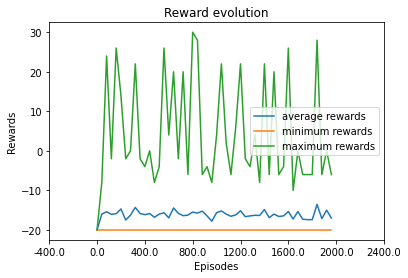

In [70]:
env = Environment()
dqlAgent = DQLAgent(env)
rewards = dqlAgent.train(NUM_EPISODES)
np.save(f"rewards_{NUM_EPISODES}_0.npy", rewards, allow_pickle=False)

# Run the simulation

In [73]:
dqlAgent.multiplay(random_actions=False)

-2182
